## File created by Reid Wyde


### Last updated 11.12.19



## todo:

doxorubicin needs to affect the entry of herceptin into the system, not its exit, or else group 3 will fit a high tau_dh and then groups 4 and 5 won't have enough herceptin to make a difference


Normalize the scaling, so that way groups 4 and 5 don't get left out




# Data Driven Growth Models for Combination Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab/Herceptin) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

### Mathematical models of tumor growth and simulation visualizations provided by Dr. Ernesto Lima, Associate Researcher at The Center for Computational Oncology at The University of Texas, 2019. 

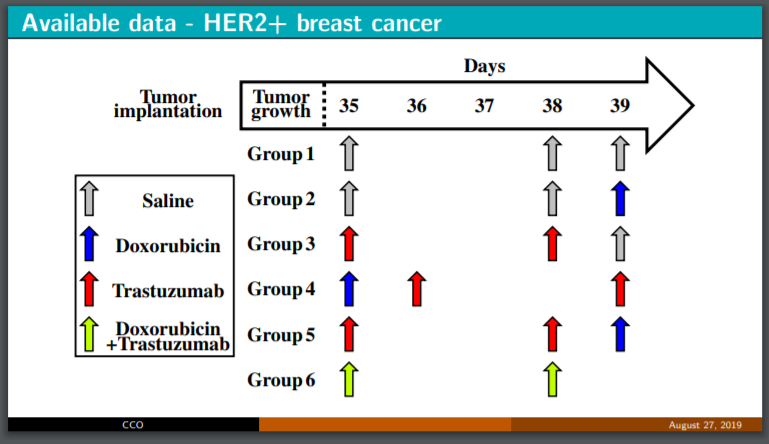

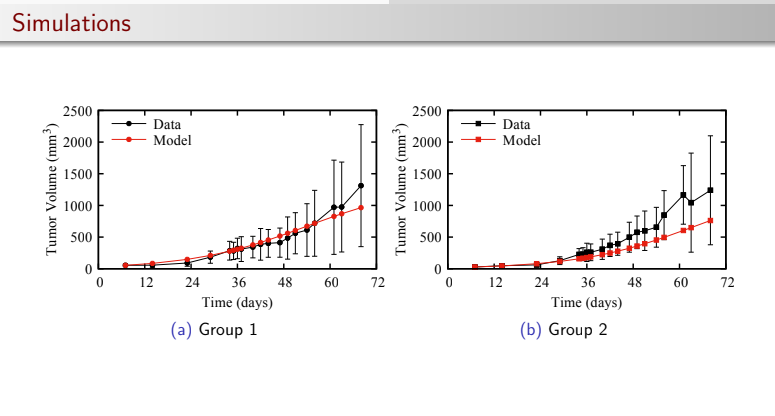

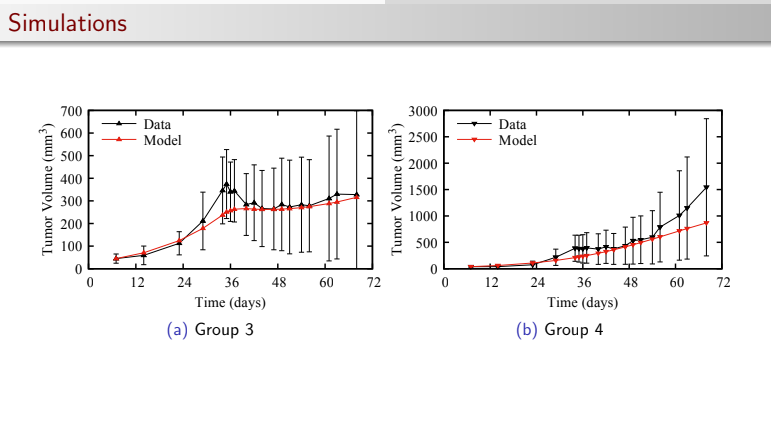

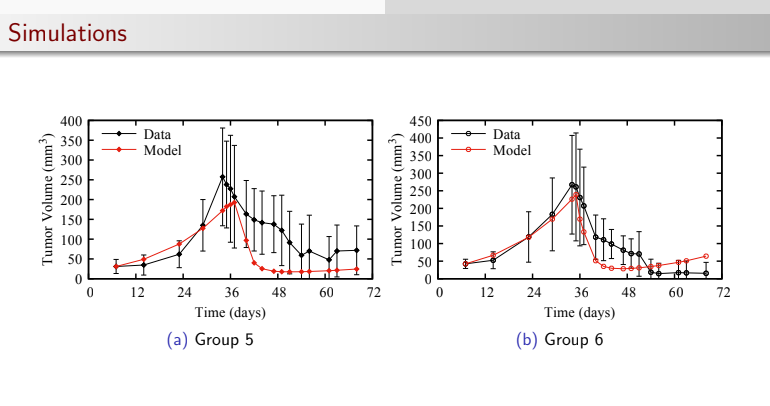

Simulation Parameters found: 

        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        tau_dh = 9.344758e+03

## Note: From here on, groups will be 0 indexed. i.e. group 0 is the control, group 5 is the simultaneous combination therapy

## General Strategy:  We will fit parameters one group at a time. Group 0 will parameterize the natural growth rate of cancer. Group 1 will parameterize Doxorubicin in isolation. Group 2 will parameterize Herceptin (Trastuzumab) in isolation. Groups 3, 4, and 5 will parameterize the drug-drug interaction. 


## This greedy strategy is motivated by the understanding that MCMC doesn't converge effectively for large dimensionality, models tend to get stuck. 

## New Model Iteration: Multiple Differential Equations

### Until now, we have considered the HER2+ cancer system as a single differential equation. We will now hypothesize that the system can be parameterized by multiple ODEs. 

### We will parameterize two different systems. The first system will be comprised of three differential equations. These equations will describe tumor growth, effective doxorubicin presence, and effective herceptin presence in the cancer system. 

### System 1:

$$ \frac{dT}{dt} = ( r - \delta_D D - \delta_{DH} D H - \delta_H H ) T  $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$



With $S_h$ and $S_D$ being considered in this model as the Kronecker delta function, occuring $\epsilon$ time after the days of treatment listed, since those datapoints were taken before treatment was given on those days.

### System 2: 

We consider the pharmacodynamics and cell signalling pathway that doxorubicin and herceptin affect. Doxorubicin has been known to increase radically oxidizing species (ROS, or 'free radicals'), e.g. quinones or ketones, and herceptin is known to supress NRF2, which is a signalling molecule that curtails the effects and amount of free radicals in the cell.  


We will consider effective free radical concentration as a latent variable, with tumor size being directly effected by the free radical concentration, and the free radical concentration being effected by both doxorubicin and herceptin. We will also consider that herceptin has immune signalling properties independent of the free radical production mechanism, and can thus affect tumor size independently of doxorubicin. We choose $O$ for the radically oxidizing species variable to avoid confusion with tumor growth rate $r$.


We also consider that doxorubicin's free radical production can destroy the receptors that herceptin binds to. This prevents herceptin from signaling on the system.



$$ \frac{dT}{dt} = (r - \delta_{HO} H O - \delta_H H ) T $$


$$ \frac{dO}{dt} = \delta_{DO} D - \tau_O O $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ 
\frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$



### system 3






$$ \frac{dT}{dt} = (r - \delta_o O - \delta_H H ) T $$


$$ \frac{dO}{dt} = \delta_{DO} D - \tau_O O + \delta_{dho} D H $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$





# Code

#### If the imports fail, run the install_packages notebook

In [1]:
#!MKL_THREADING_LAYER=GNU

In [2]:
#visualization
import matplotlib.pyplot as plt
#arrays
import numpy as np

#file system
import os
import platform

#CSV read
import pandas as pd

#model building
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

np.random.seed(123)

In [3]:
if platform.system() == 'Windows':  # check the file system formatting
    filtered_filename = os.getcwd() + '\..\data\\filtered_data_csv.csv'
else:
    filtered_filename = os.getcwd() + '/../data//filtered_data_csv.csv'
    
tumor_size_db = pd.read_csv(filtered_filename)
#tumor_size_db.head()

In [4]:
ts = np.array(tumor_size_db['Day']).transpose() # dimension: (19,)
Ts = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

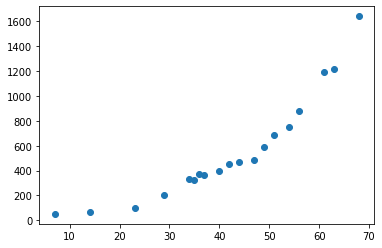

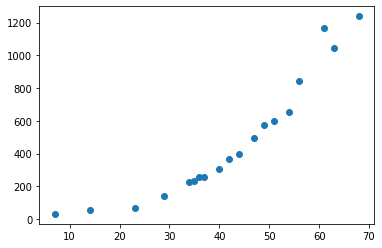

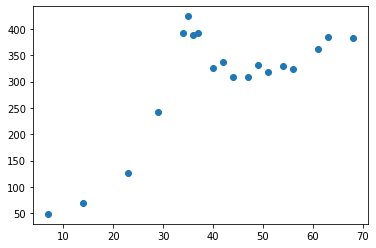

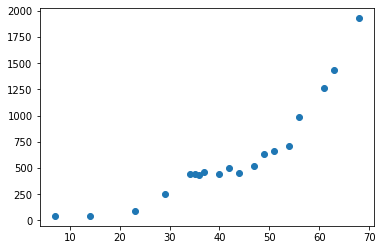

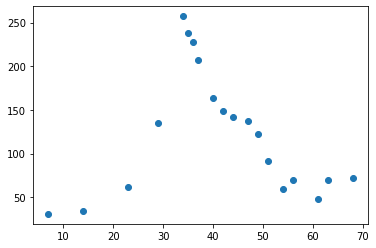

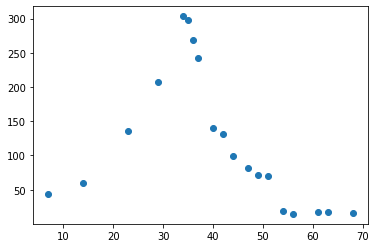

In [5]:
for ii in range(6):

    plt.figure()
    plt.scatter(ts.ravel(), Ts[ii,:].ravel())
    plt.show()

In [6]:
def get_tt(tuple_treatment_group):
    switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])

## Treatment concentration model - decaying exponential

In [7]:
def get_Sd(tau_d, t):
    Sd = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('dox',group))
        for tt in treatment_times:
            Sd[group] = Sd[group] + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh(tau_h, tau_dh, Sd, t):
    Sh = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('her',group))
        for tt in treatment_times:
            tau = tau_h + tau_dh*Sd            
            # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
            # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
            # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
            Sh[group] = Sh[group] + np.nan_to_num(np.exp(-tau[group]*(t-tt)))*np.heaviside(t-tt, 0) 
    return Sh


def get_Sd_by_group(tau_d, t, group): 
    Sd = 0
    treatment_times = get_tt(('dox',group))
    for tt in treatment_times:
        Sd = Sd + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh_by_group(tau_h, tau_dh, Sd, t, group):
    Sh = 0
    treatment_times = get_tt(('her',group))
    for tt in treatment_times:
        tau = tau_h + tau_dh*Sd            
        # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
        # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
        # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
        Sh = Sh + np.nan_to_num(np.exp(-tau*(t-tt)))*np.heaviside(t-tt, 0) 
    return Sh




## Treatment concentration model - impulse

In [8]:
def get_Sd_impulse(ts):
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('dox', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Sds[group, ii] = 1
    return Sds
    

def get_Sh_impulse(ts):
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('her', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Shs[group, ii] = 1
    return Shs


def get_Sd_impulse_by_group(ts, group):
    Sds = np.zeros((1, len(ts)))
    treatment_times = get_tt(('dox', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Sds[0, ii] = 1
    return Sds
    
def get_Sh_impulse_by_group(ts, group):
    Shs = np.zeros((1, len(ts)))
    treatment_times = get_tt(('her', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Shs[0, ii] = 1
    return Shs





### Treatment calculation unit tests

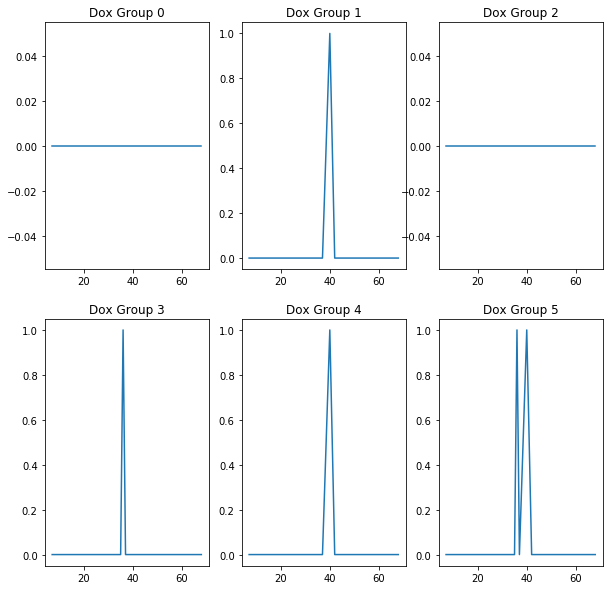

In [9]:
"""
def test_treatment_Sd():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd()
"""

def test_treatment_Sd_impulse():
    tau_d=0.1
    #ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = get_Sd_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd_impulse()




C:\Users\Reid\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


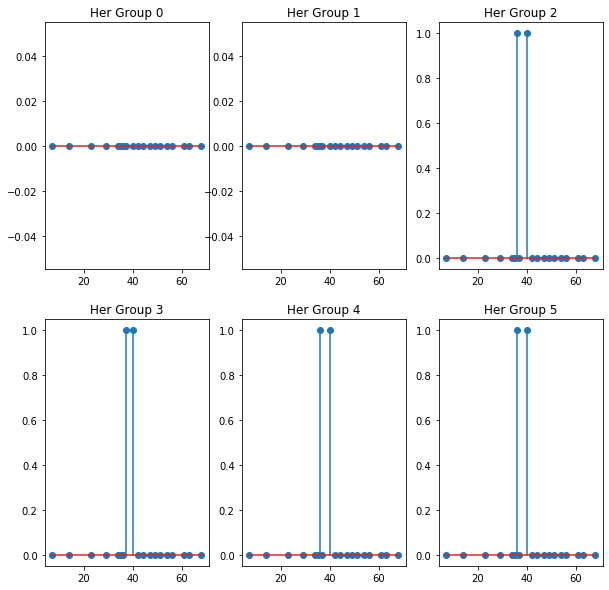

In [10]:
"""
def test_treatment_Sh():
    tau_h=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
        Shs[:,ii] = get_Sh(tau_h, tau_dh, Sds[:,ii], ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh()

"""



def test_treatment_Sh_impulse():
    #ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = get_Sh_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh_impulse()


C:\Users\Reid\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


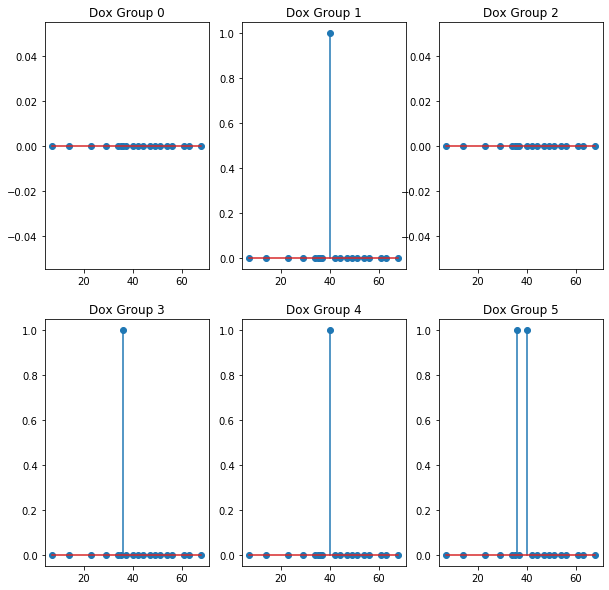

In [11]:
"""def test_treatment_Sd_by_group():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        for jj in range(6):
            Sds[jj,ii] = get_Sd_by_group(tau_d, ts[ii], jj)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd_by_group()

"""

def test_treatment_Sd_impulse_by_group():
    #ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        Sds[group,:] = get_Sd_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Sds[group])
    plt.show()
    return


test_treatment_Sd_impulse_by_group()



C:\Users\Reid\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


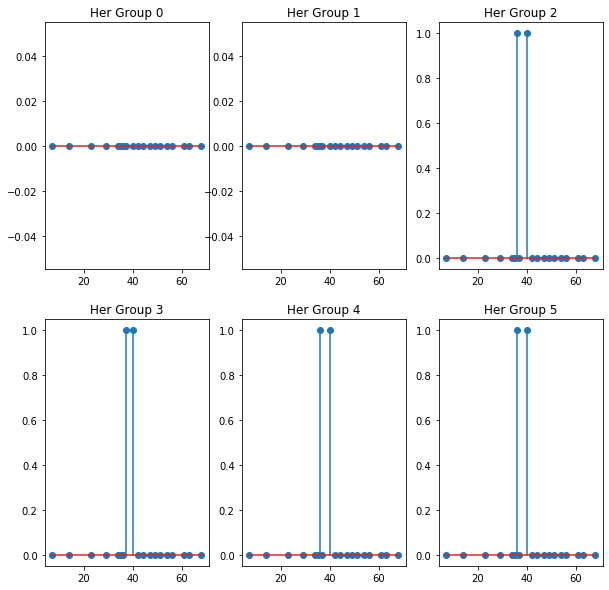

In [12]:
"""
def test_treatment_Sh_by_group():
    tau_h=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        for jj in range(6):
            Sds[jj,ii] = get_Sd_by_group(tau_d, ts[ii], jj)
            Shs[jj,ii] = get_Sh_by_group(tau_h, tau_dh, Sds[jj,ii], ts[ii], jj)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh_by_group()

"""

def test_treatment_Sh_impulse_by_group():
    #ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        Shs[group,:] = get_Sh_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].stem(ts, Shs[group])
    plt.show()
    return


test_treatment_Sh_impulse_by_group()




## Simulation Graphing Methods

In [13]:
sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7

def graph_sim_by_group(sim_times, T_sim, group):
    plt.figure(figsize=[4,2.5])
    plt.scatter(ts, Ts[group,:])
    plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
    plt.plot(sim_times, T_sim)
    plt.title('Group ' + str(group))
    plt.xlabel('Day')
    plt.ylabel('Size')
    plt.show()
    
def graph_sim(sim_times, T_sim):
    plt.figure(figsize=[16,10])
    for group in range(6):
        plt.subplot(2,3,group+1)
        plt.scatter(ts, Ts[group,:])
        plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
        plt.plot(sim_times, T_sim[group,:])
        plt.title('Group ' + str(group))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()

## Forward DE Models

In [14]:
def rk_var_update(var, ks):
    k1, k2, k3, k4 = [x for x in ks]
    var = var + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    var[var<0] = 0
    return var

def rk_T(h, t0, T, H, O, params, j, dTdt):
    k1 = h * dTdt(t0, T, H, O, params, j) 
    k2 = h * dTdt(t0+0.5*h, T + 0.5 * k1, H, O, params, j) 
    k3 = h * dTdt(t0+0.5*h, T + 0.5 * k2, H, O, params, j) 
    k4 = h * dTdt(t0+h, T + k3, H, O, params, j)   
    return k1, k2, k3, k4

def rk_D(h, t0, D, params, j, dDdt):
    k1 = h * dDdt(t0, D, params, j) 
    k2 = h * dDdt(t0+0.5*h, D + 0.5 * k1, params, j) 
    k3 = h * dDdt(t0+0.5*h, D + 0.5 * k2, params, j) 
    k4 = h * dDdt(t0+h, D + k3, params, j)   
    return k1, k2, k3, k4
    
def rk_H(h, t0, H, D, params, j, dHdt):
    k1 = h * dHdt(t0, H, D, params, j) 
    k2 = h * dHdt(t0+0.5*h, H + 0.5 * k1, D, params, j) 
    k3 = h * dHdt(t0+0.5*h, H + 0.5 * k2, D, params, j) 
    k4 = h * dHdt(t0+h, H + k3, D, params, j) 
    return k1, k2, k3, k4

def rk_O(h, t0, O, D, H, params, j, dOdt):
    k1 = h * dOdt(t0, O, D, H, params, j) 
    k2 = h * dOdt(t0+0.5*h, O + 0.5 * k1, D, H, params, j) 
    k3 = h * dOdt(t0+0.5*h, O + 0.5 * k2, D, H, params, j) 
    k4 = h * dOdt(t0+h, O + k3, D, H, params, j)
    return k1, k2, k3, k4

def rungeKutta_all_params(ts, T0, dTdt, dDdt, dHdt, dOdt, Sds, Shs, params):
    time_len = len(ts.ravel())
    ret_T = np.zeros((T0.shape[0], time_len))
    ret_D = np.zeros(ret_T.shape)
    ret_H = np.zeros(ret_T.shape)
    ret_O = np.zeros(ret_T.shape)
    T = T0
    D = ret_D[:,0]
    H = ret_H[:,0]
    O = ret_O[:,0]
    ret_T[:, 0] = T0
    for i in range(1, time_len):
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0
        Sd = Sds[:,i-1]
        Sh = Shs[:,i-1]

        D_new = rk_var_update(D, rk_D(h, t0, D, params, i-1, dDdt))
        H_new = rk_var_update(H, rk_H(h, t0, H, D, params, i-1, dHdt))
        O_new = rk_var_update(O, rk_O(h, t0, O, D, H, params, i-1, dOdt))
        T_new = rk_var_update(T, rk_T(h, t0, T, H, O, params, i-1, dTdt))
        
        D = D_new + Sd
        H = H_new + Sh
        O = O_new         
        T = T_new 
        
        ret_T[:,i] = T
        ret_D[:,i] = D
        ret_H[:,i] = H
        ret_O[:,i] = O
    
    return ret_T, ret_D, ret_H, ret_O


def get_Sd_impulse_Combination(ts):
    Sds = np.zeros((4, len(ts)))
    group_idxs = [1,3,4,5]
    for ii in range(4):
        group_idx = group_idxs[ii]
        treatment_times = get_tt(('dox', group_idx))
        for tt in treatment_times:
            jj = np.where(ts > tt)[0][0]
            Sds[ii, jj] = 1
    return Sds

def get_Sh_impulse_Combination(ts):
    Shs = np.zeros((4, len(ts)))
    group_idxs = [1,3,4,5]
    for ii in range(4):
        group_idx = group_idxs[ii]
        treatment_times = get_tt(('her', group_idx))
        for tt in treatment_times:
            jj = np.where(ts > tt)[0][0]
            Shs[ii, jj] = 1
    return Shs

## Growth Model Class

In [15]:
class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0
   
    def get_param(self, param_name, n=10):
        return pm.summary(self.trace)['mean'][param_name]

## Logistic Growth Model
### Used to fit to group 0 data


$$ \frac{dT}{dt} = (r - \delta_o O - \delta_H H ) T $$


$$ \frac{dO}{dt} = \delta_{DO} D - \tau_O O + \delta_{dho} D H $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$



In [17]:
class growth_model_natural(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[0,0])
        self.group_num = 0
        
    def _simulate(self, params, times):
        T_values = rungeKutta_T(times, self._T0, self.dTdt, params)
        return T_values
    
    def simulate(self, r, times=None):
        if times is None: times = self._times        
        return self._simulate([r], times)
    
    def dTdt(self, t, T, H, O, params, i):
        r = params[0]
        return T*r
    
    def backward(self):
        T_obs = Ts[0,:]
        #sigmas_obs = sigmas[0,:]/100
        sigmas_obs = np.ones(T_obs.shape)
        with pm.Model():
            self.param_list = ['r']
            r_lower = 0.0001
            r_upper = 0.1
            #K_lower = 0.0
            #K_upper = 20000
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            #K = pm.Uniform('K', lower=K_lower, upper=K_upper)

            ## Theano wrapper is necessary in order to pass the forward evolution to PyMC3
            @as_op(itypes=[tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r):
                th_states = self.simulate(r)
                return th_states
            
            forward = th_forward_model(r)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 3 # more is better. This is how the MCMC calculation is easily distributed between cores
            startsmc=[{'r':np.random.uniform(r_lower, r_upper),                     
                      } for _ in range(n_chains)]
            num_samples = 1200 # longer is better. Within each chain, operations are sequential and cannot be parallelized.
            num_tune = int(num_samples/5)
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace)
            
            
            
    def fit_sim_graph_model():
        this_model = growth_model_natural()
        this_model.backward()
        r = this_model.get_param('r')
        T_sim = this_model.simulate(r, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 0)
        print('r: ' + str(r))

        return r


            
#r = growth_model_natural.fit_sim_graph_model()

r = 0.06
#K = 7161

## Herceptin Treatment


$$ \frac{dT}{dt} = (r - \delta_o O - \delta_H H ) T $$


$$ \frac{dO}{dt} = \delta_{DO} D - \tau_O O + \delta_{dho} D H $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$



C:\Users\Reid\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


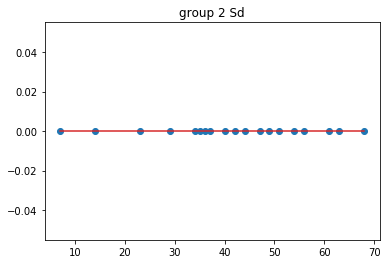

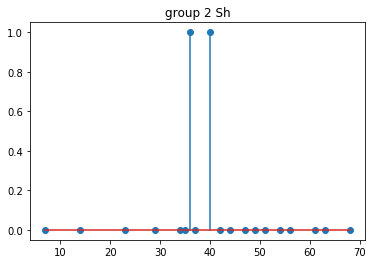

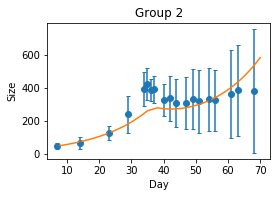

delta_h: 0.04
tau_h: 0.05


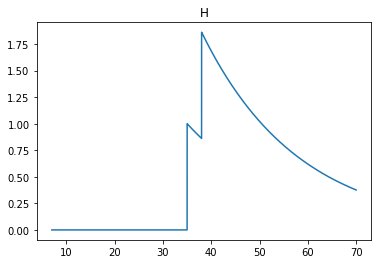

In [18]:
class growth_model_her(growth_model):
    def __init__(self):
        super().__init__(ts, np.array(Ts[2,0]).reshape(-1,1))
        self.group_num = 2
        self._times = ts
        
        self.Sds_fit = get_Sd_impulse_by_group(ts, 2)
        self.Shs_fit = get_Sh_impulse_by_group(ts, 2)
        
        self.Sds_sim = get_Sd_impulse_by_group(sim_times, 2)
        self.Shs_sim = get_Sh_impulse_by_group(sim_times, 2)
        
        self.Sds = self.Sds_fit
        self.Shs = self.Shs_fit 
         
        self.groups = [2]
        for ii in range(len(self.groups)):
            group = str(self.groups[ii])
            self.stem_short(ts, self.Sds[ii,:], 'group ' + group + ' Sd')
            self.stem_short(ts, self.Shs[ii,:], 'group ' + group + ' Sh')
            
        
    def _simulate(self, params, times):
        self.sim_T, self.sim_D, self.sim_H, self.sim_O = rungeKutta_all_params(times, \
                            self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, params)
        return self.sim_T
        
    def simulate(self, delta_h, tau_h, times=None):
        if times is None: times = self._times
        return self._simulate([delta_h, tau_h], times)
    
    def dHdt(self, t, H, D, params, Sh):
        delta_h, tau_h = [x for x in params]
        #print('dHdt terms')
        #print(Sh)
        #print(tau_h)
        #print(H)
        return -tau_h*H
    
    
    def dDdt(self, t, D, params, i):
        return 0
        
    def dOdt(self, t, O, D, H, params, i):
        return 0
    
    def dTdt(self, t, T, H, O, params, i):
        delta_h, tau_h  = [x for x in params] 
        return (r - delta_h*H)*T
    
    def backward(self):
        T_obs = np.array(Ts[2,:]).reshape(1,-1)
        #sigmas_obs = sigmas[2,:]/100
        sigmas_obs = np.ones(T_obs.shape)*50
        self.param_list = ['delta_h', 'tau_h']
        self.Shs = get_Sh_impulse_by_group(self._times, self.group_num)
        #plt.figure()
        #plt.stem(self._times.ravel(), self.Shs.ravel())
        #plt.show()
        #self.Hs = H_rungeKutta(self._times, self.Shs, self.dHdt, [0, 0])
        with pm.Model():
            self.param_list = ['delta_h', 'tau_h']
            delta_h_lower = 0
            delta_h_upper = 1            
            
            tau_h_lower = 0
            tau_h_upper = 1
            
            
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)

            #delta_h = pm.Normal('delta_h', mu=(delta_h_lower + delta_h_upper)/2, sd=3)
            #tau_h = pm.Normal('tau_h', mu=(tau_h_lower + tau_h_upper)/2, sd=3)

            
            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(tau_h, delta_h):
                th_states = self.simulate(delta_h, tau_h)
                return th_states
            
            forward = th_forward_model(delta_h, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 5
            startsmc=[{'tau_h':np.random.uniform(tau_h_lower, tau_h_upper), 
                       'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def fit_sim_graph_model():
        this_model = growth_model_her()
        this_model.backward()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        #return
        delta_h, tau_h = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(delta_h, tau_h, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 2)
        print('delta_h: ' + str(delta_h))
        print('tau_h: ' + str(tau_h))
        
        this_model.plot_short(sim_times, this_model.sim_H, 'H')

        return delta_h, tau_h
    

    
    def sim_graph_model():
        this_model = growth_model_her()
        #this_model.backward()
        #return
        #delta_h, tau_h = [this_model.get_param(x) for x in this_model.param_list]
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        delta_h = 0.04
        tau_h = 0.05
        T_sim = this_model.simulate(delta_h, tau_h, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 2)
        print('delta_h: ' + str(delta_h))
        print('tau_h: ' + str(tau_h))
        
        this_model.plot_short(sim_times, this_model.sim_H, 'H')
        
        return delta_h, tau_h
    
    def plot_short(self, times, var, title):
        plt.figure()
        plt.plot(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
        
    def stem_short(self, times, var, title):
        plt.figure()
        plt.stem(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
    

            
#delta_h, tau_h = growth_model_her.fit_sim_graph_model()


delta_h, tau_h = growth_model_her.sim_graph_model()

## Doxorubicin treatment


$$ \frac{dT}{dt} = (r - \delta_o O - \delta_H H ) T $$


$$ \frac{dO}{dt} = \delta_{DO} D - \tau_O O + \delta_{dho} D H $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$

Can't be parameterized in isolation. Needs the combination with herceptin based on this system

## Combinational Therapy

C:\Users\Reid\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


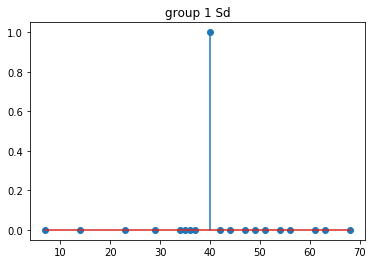

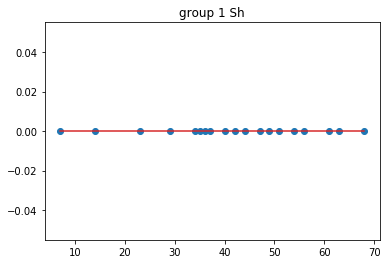

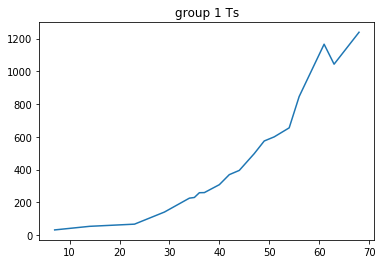

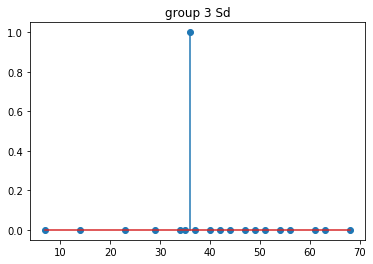

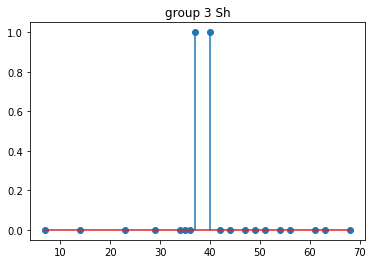

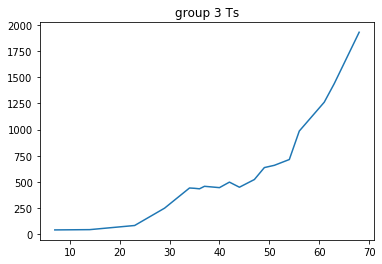

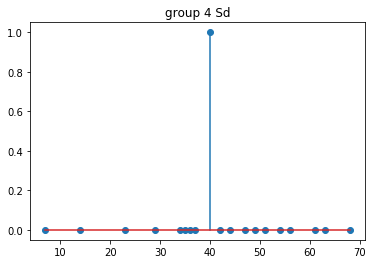

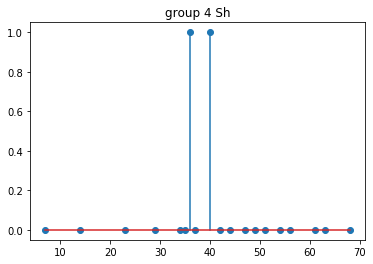

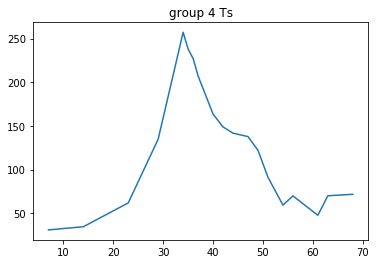

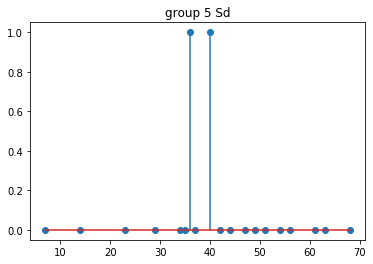

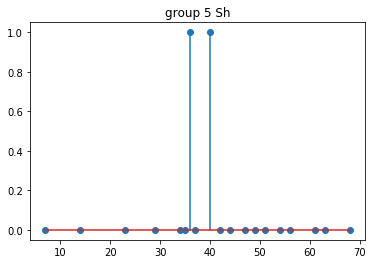

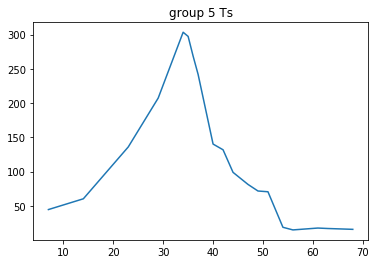

(4, 19)
(4, 19)


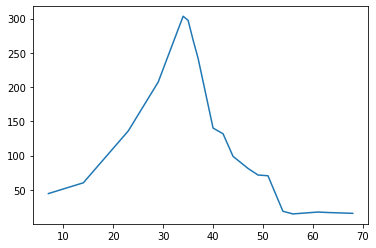

Only 20 samples in chain.
Sequential sampling (20 chains in 1 job)
CompoundStep
>Metropolis: [delta_dho]
>Metropolis: [delta_do]
>Metropolis: [delta_o]
>Metropolis: [tau_dh]
>Metropolis: [tau_o]
>Metropolis: [tau_d]
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 18.54it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


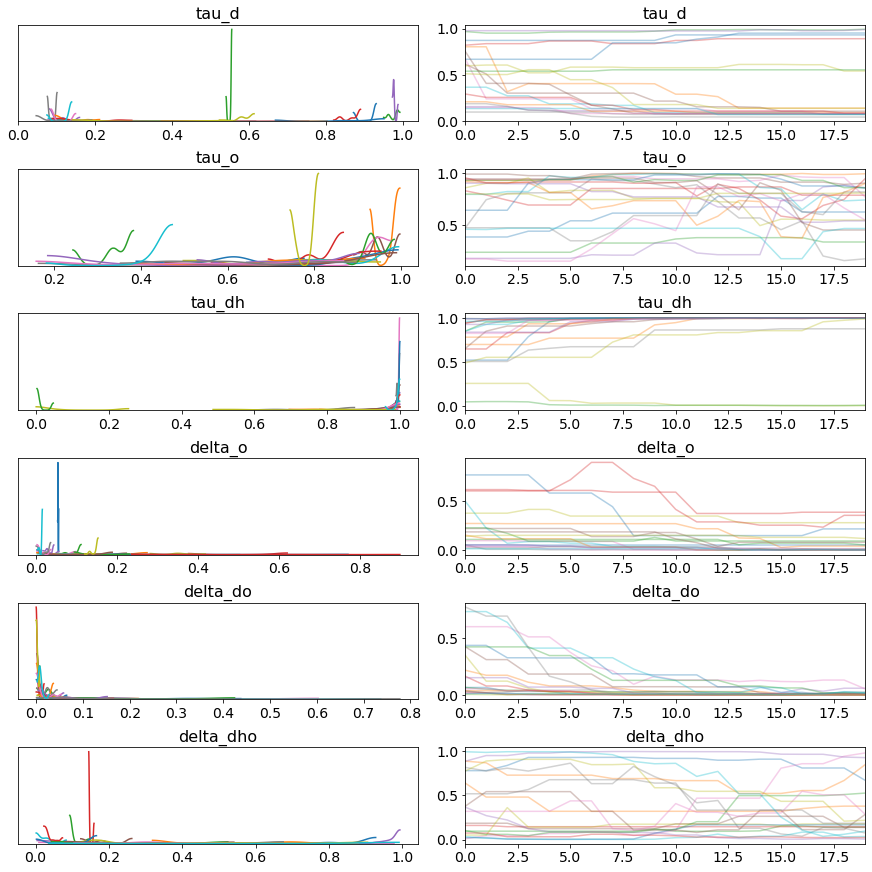

<Figure size 288x180 with 0 Axes>

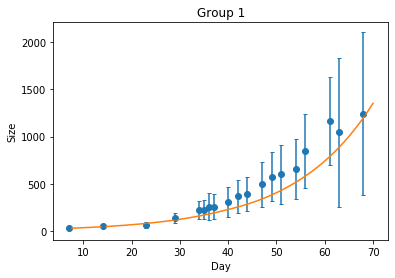

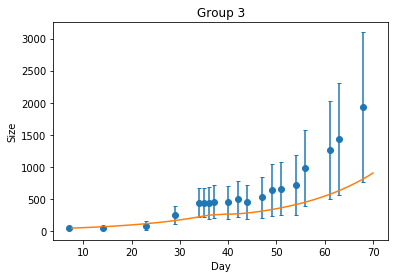

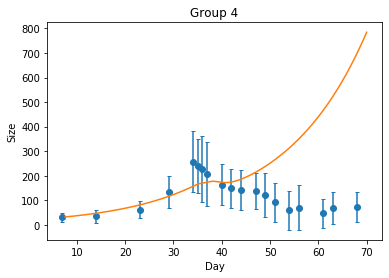

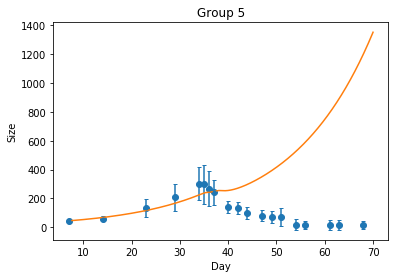

delta_dho: 0.35983402887000915
delta_do: 0.07134176968248297
delta_o: 0.14128961236606494
tau_dh: 0.8503708845709187
tau_o: 0.7274737243798122
tau_d: 0.3924252225028137


In [21]:
class growth_model_dd_interaction(growth_model):
    
    def __init__(self):
        super().__init__(ts, np.concatenate(([Ts[1,0]],[Ts[3,0]],[Ts[4,0]],[Ts[5,0]]), axis=0))
        self.Sds_fit = get_Sd_impulse_Combination(ts)
        self.Shs_fit = get_Sh_impulse_Combination(ts)
        
        self.Sds_sim = get_Sd_impulse_Combination(sim_times)
        self.Shs_sim = get_Sh_impulse_Combination(sim_times)
        
        self.Sds = self.Sds_fit
        self.Shs = self.Shs_fit       

        self.groups = [1,3,4,5]
        for ii in range(len(self.groups)):
            group = str(self.groups[ii])
            self.stem_short(ts, self.Sds[ii,:], 'group ' + group + ' Sd')
            self.stem_short(ts, self.Shs[ii,:], 'group ' + group + ' Sh')
            self.plot_short(ts, Ts[self.groups[ii],:], 'group ' + group + ' Ts')
        
    def _simulate(self, params, times):
        self.sim_T, self.sim_D, self.sim_H, self.sim_O = rungeKutta_all_params(times, \
                            self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, params)
        return self.sim_T
    
    def simulate(self, delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d], times)
    
    def dDdt(self, t, D, params, i):
        delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d = [x for x in params]
        return -tau_d*D
    
    def dHdt(self, t, H, D, params, i):
        delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d = [x for x in params]
        return -tau_h*H - tau_dh*D*H
    
    def dOdt(self, t, O, D, H, params, i):
        delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d  = [x for x in params]
        return delta_do*D - tau_o*O + delta_dho*D*H
    
    def dTdt(self, t, T, H, O, params, i):
        delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d = [x for x in params]
        return (r - delta_o*O - delta_h*H)*T
    
    def backward(self):
        T_obs = Ts[self.groups,:]
        #sigmas_obs = sigmas[3:6,:]
        sigmas_obs = np.ones(T_obs.shape)*50
        print(T_obs.shape)
        print(sigmas_obs.shape)

        plt.figure()
        plt.plot(ts, T_obs[3,:])
        plt.show()
        
        with pm.Model():          
            self.param_list = ['delta_dho', 'delta_do', 'delta_o', 'tau_dh', 'tau_o', 'tau_d']
            
            
            delta_dho_lower = 0
            delta_dho_upper = 1
            
            delta_do_lower = 0
            delta_do_upper = 1
            
            delta_o_lower = 0
            delta_o_upper = 1
            
            tau_dh_lower = 0
            tau_dh_upper = 1
            
            tau_o_lower = 0
            tau_o_upper = 1
            
            tau_d_lower = 0
            tau_d_upper = 1
                      
            
            tau_d = pm.Uniform('tau_d', lower= tau_d_lower, upper= tau_d_upper)
            
            tau_o = pm.Uniform('tau_o', lower= tau_o_lower, upper= tau_o_upper)
            
            tau_dh = pm.Uniform('tau_dh', lower= tau_dh_lower, upper= tau_dh_upper)
            
            delta_o = pm.Uniform('delta_o', lower= delta_o_lower, upper= delta_o_upper)
            
            delta_do = pm.Uniform('delta_do', lower= delta_do_lower, upper= delta_do_upper)
            
            delta_dho = pm.Uniform('delta_dho', lower= delta_dho_lower, upper= delta_dho_upper)
            
            
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d ):
                th_states = self.simulate(delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d )
                return th_states
            
            forward = th_forward_model(delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 20
            startsmc=[{'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),
                       'tau_o':np.random.uniform(tau_o_lower, tau_o_upper),
                       'tau_dh':np.random.uniform(tau_dh_lower, tau_dh_upper),
                       'delta_o':np.random.uniform(delta_o_lower, delta_o_upper),
                       'delta_do':np.random.uniform(delta_do_lower, delta_do_upper),
                       'delta_dho':np.random.uniform(delta_dho_lower, delta_dho_upper),
                      } for _ in range(n_chains)]
            num_samples = 20
            num_tune = int(num_samples/5)
            #step = pm.Slice()
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace)
            
            
    def plot_short(self, times, var, title):
        plt.figure()
        plt.plot(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
        
    def stem_short(self, times, var, title):
        plt.figure()
        plt.stem(times.ravel(), var.ravel())
        plt.title(title)
        plt.show()
                
    def graph_sims(self, sim_times, T_sim):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            group = self.groups[ii]
            plt.figure()
            plt.scatter(ts, Ts[group,:])
            plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.', capsize=2)
            plt.plot(sim_times, T_sim[ii,:])
            plt.title('Group ' + str(group))
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
            
        self.sim_D, self.sim_H, self.sim_O 
            
                
    def graph_Sds(self, times):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            plt.figure()
            group = self.groups[ii]
            plt.stem(times, self.Sds[ii, :])
            plt.title('Group ' + str(group) + ' Sd')
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
    
    def graph_Shs(self, times):
        plt.figure(figsize=[4,2.5])
        for ii in range(len(self.groups)):
            plt.figure()
            group = self.groups[ii]
            plt.stem(times, self.Shs[ii, :])
            plt.title('Group ' + str(group) + ' Sh')
            plt.xlabel('Day')
            plt.ylabel('Size')
            plt.show()
    
    
    def fit_sim_graph_model():
        this_model = growth_model_dd_interaction()
        this_model.backward()
        delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        T_sim = this_model.simulate(delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d, sim_times)
        this_model.graph_sims(sim_times, T_sim)

        
        print('delta_dho: ' + str(delta_dho))      
        print('delta_do: ' + str(delta_do))   
        print('delta_o: ' + str(delta_o))
        print('tau_dh: ' + str(tau_dh)) 
        print('tau_o: ' + str(tau_o))
        print('tau_d: ' + str(tau_d))

        
        return delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d
    
    def sim_graph_model():
        this_model = growth_model_dd_interaction()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        
        delta_dho= 0.4006802262184397
        delta_do= 0.1777281291791059
        delta_o = 0.02201329399771636
        tau_dh = 0.9292073063611829
        tau_o = 0.5923535472781384
        tau_d = 0.3378852262534219
        
        T_sim = this_model.simulate(delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d, sim_times)
        
        this_model.graph_sims(sim_times, T_sim)
        
        
        #print sds
        #print shs
        #print D
        #print H
        #print O
        
        print('delta_dho: ' + str(delta_dho))      
        print('delta_do: ' + str(delta_do))   
        print('delta_o: ' + str(delta_o))
        print('tau_dh: ' + str(tau_dh)) 
        print('tau_o: ' + str(tau_o))
        print('tau_d: ' + str(tau_d))

        return delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d
    
        

            
delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d = growth_model_dd_interaction.fit_sim_graph_model()
#delta_dho, delta_do, delta_o, tau_dh, tau_o, tau_d = growth_model_dd_interaction.sim_graph_model()



$$ \frac{dT}{dt} = (r - \delta_o O - \delta_H H ) T $$


$$ \frac{dO}{dt} = \delta_{DO} D - \tau_O O + \delta_{dho} D H $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D
\;\;\;\;
or 
\;\;\;\;
\frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H 
$$

Can't be parameterized in isolation. Needs the combination with herceptin based on this system

## My findings

In [ ]:
print('r = ' + str(r))
print('delta_h = ' + str(delta_h))
print('tau_h = ' + str(tau_h))
print('delta_do: ' + str(delta_do))
print('delta_ho: ' + str(delta_ho))
print('tau_d = ' + str(tau_d))
print('tau_dh: ' + str(tau_dh))
print('tau_o: ' + str(tau_o)) 

## Simulate parameters found by Dr. Lima


Dr. Lima's Parameters

r = 6.773495e-02
k = 1.331254e+03
delta_h = 3.165840e-02
tau_h = 1.696031e-02
delta_d = 6.548050e-05
tau_d = 3.001805e-01
delta_dh = 4.327301e-01
tau_dh = 9.344758e+03




New Params

